In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [156]:
def testare_homoschedasticitate(regression,actual):
    residuals = regression.resid
    exog = regression.model.exog
    print("Testul White")
    white_t = het_white(residuals,exog)
    print(white_t)
    print("Test Breuche-Pagan")
    bpt = het_breuschpagan(residuals,exog)
    print(bpt)
    plt.figure(figsize=(10,8))
    plt.scatter(actual,residuals)
    plt.xlabel("Valori reale")
    plt.ylabel("Valori estimate")
    plt.title("Real vs Estimat")
    plt.show()

In [157]:
def testare_normalitate(regresie,bins):
    #Testare normalitate
    reziduuri = regresie.resid
    jb = jarque_bera(reziduuri)
    print("jarque_bera")
    print(jb)
    print("SHAPIRO")
    shapiro_test = shapiro(reziduuri)
    print(shapiro_test)
    print("Kolmogov Smirnov")
    print(kstest(reziduuri, "norm", args=(reziduuri.mean(), reziduuri.std())))
    plt.figure(figsize=(10,6))
    plt.title("Distributia erorilor")
    plt.hist(reziduuri,bins=bins)
    plt.show()

In [3]:
df =  pd.read_csv("World-happiness-report-2024.csv",index_col="Country name")

In [4]:
df.head()

,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
Country name,,,,,,,,,,,
Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082
Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881
Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050
Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658
Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298


In [5]:
df.dropna(inplace=True)

In [6]:
# print(df['Regional indicator'].drop_duplicates())
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [7]:
print(Asia)
print(Europe)
print(North_America)
print(Australia)
print(Africa)
print(Countries_not_in_middle_east)
print(African_countries)

['Southeast Asia', 'East Asia', 'South Asia']
['Western Europe', 'Central and Eastern Europe']
['United States', 'Canada']
['Australia', 'New Zealand']
['Sub-Saharan Africa']
['Ukraine', 'Moldova', 'Georgia']
['Libya', 'Algeria', 'Morocco', 'Tunisia', 'Egypt']


In [8]:
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)

In [9]:
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)

In [134]:
regresie = smf.ols('happy ~Social_support + '
                            '+ Coruption +GDP_capita_logged + Freedom',data=df).fit()
print(regresie.summary())
exog = regresie.model.exog
fit = regresie.fittedvalues
weigths = 1 / (np.power(fit,2))
wls = sm.WLS(df.loc[df.dropna().index,'happy'],exog=exog,weights=weigths).fit()

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     142.0
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           2.40e-47
Time:                        23:54:07   Log-Likelihood:                -105.98
No. Observations:                 140   AIC:                             222.0
Df Residuals:                     135   BIC:                             236.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2720      0.19

Testul White
(24.020444831473643, 0.04556249141660305, 1.8491902052239688, 0.038414596600685545)
Test Breuche-Pagan
(12.917058107829273, 0.0116882544228665, 3.43044239178174, 0.010501656459964079)


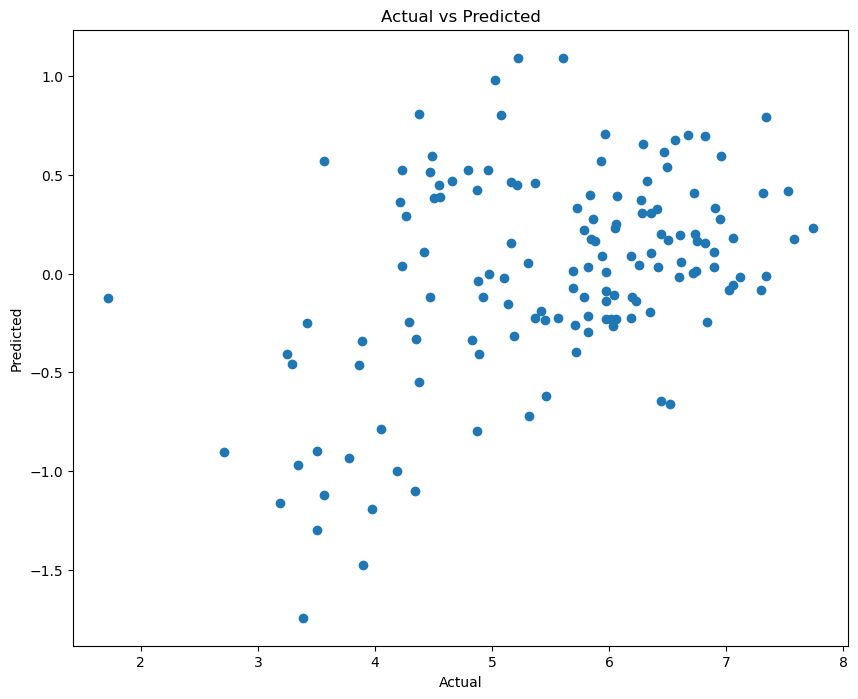

In [110]:
testare_homoschedasticitate(regresie,df.loc[df.dropna().index,'happy'])

In [111]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.841
Model:                            WLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     178.4
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           7.53e-53
Time:                        23:47:12   Log-Likelihood:                -121.97
No. Observations:                 140   AIC:                             253.9
Df Residuals:                     135   BIC:                             268.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3218      0.154      8.558      0.0

Testul White
(21.718183026567175, 0.08459340515766611, 1.6394096185979892, 0.07742080885151538)
Test Breuche-Pagan
(11.249677216267017, 0.023896755136856056, 2.94893711984528, 0.022499449166239503)


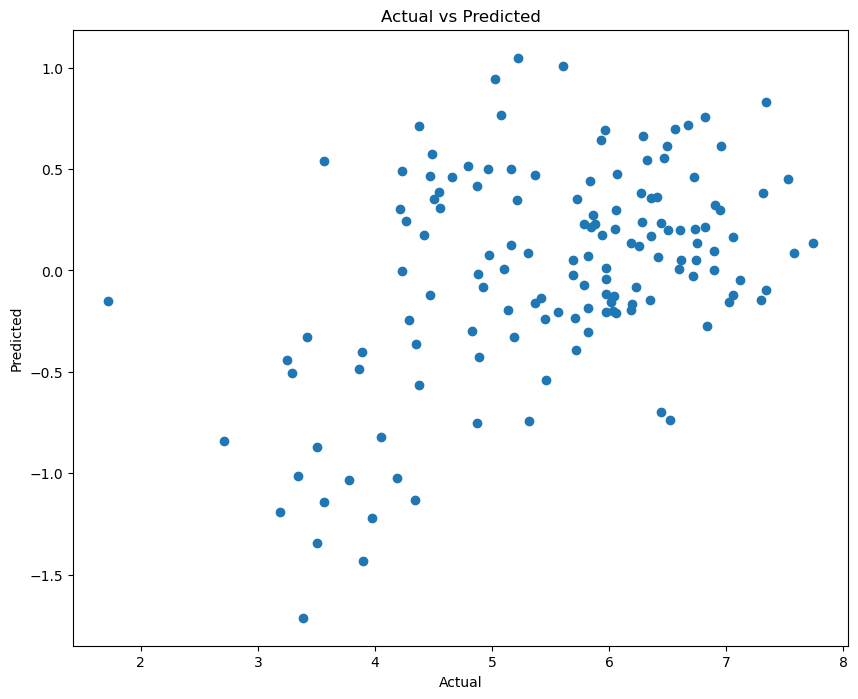

In [112]:
testare_homoschedasticitate(wls,df.loc[df.dropna().index,'happy'])

In [113]:
model_corectat = regresie.get_robustcov_results(cov_type='HC3')
print(model_corectat.summary())

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     158.2
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           6.35e-50
Time:                        23:47:13   Log-Likelihood:                -105.98
No. Observations:                 140   AIC:                             222.0
Df Residuals:                     135   BIC:                             236.7
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2720      0.22

Testul White
(24.020444831473643, 0.04556249141660305, 1.8491902052239688, 0.038414596600685545)
Test Breuche-Pagan
(12.917058107829273, 0.0116882544228665, 3.43044239178174, 0.010501656459964079)


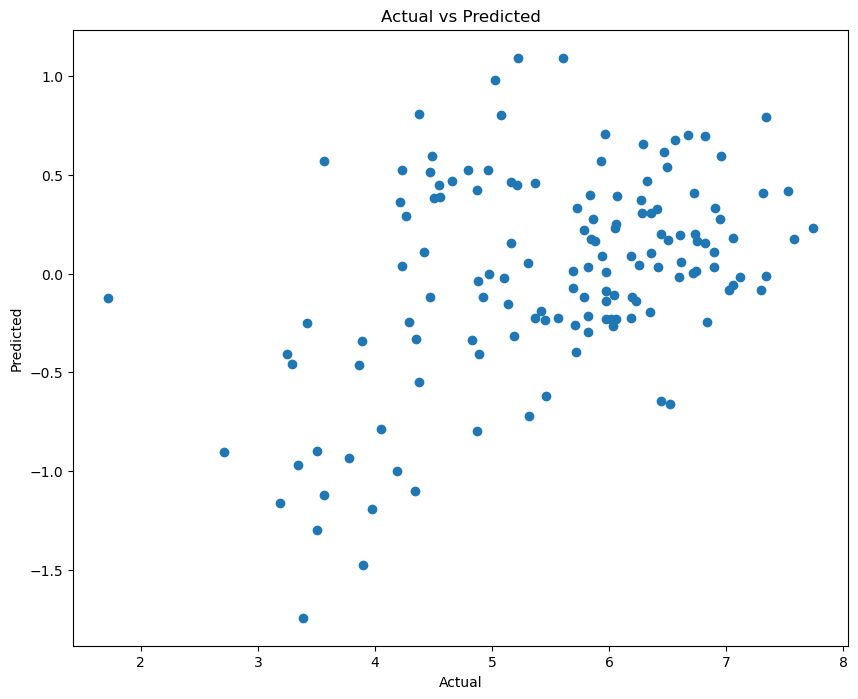

In [114]:
testare_homoschedasticitate(model_corectat,df.loc[df.dropna().index,'happy'])

jarque_bera
(15.626857648242652, 0.00040426949962496435, -0.7254420067944015, 3.757512680863053)
SHAPIRO
ShapiroResult(statistic=0.9636826515197754, pvalue=0.0008976628305390477)
Kolmogov Smirnov
KstestResult(statistic=0.0955728750486037, pvalue=0.14518244946705527, statistic_location=-0.26744831550402015, statistic_sign=-1)


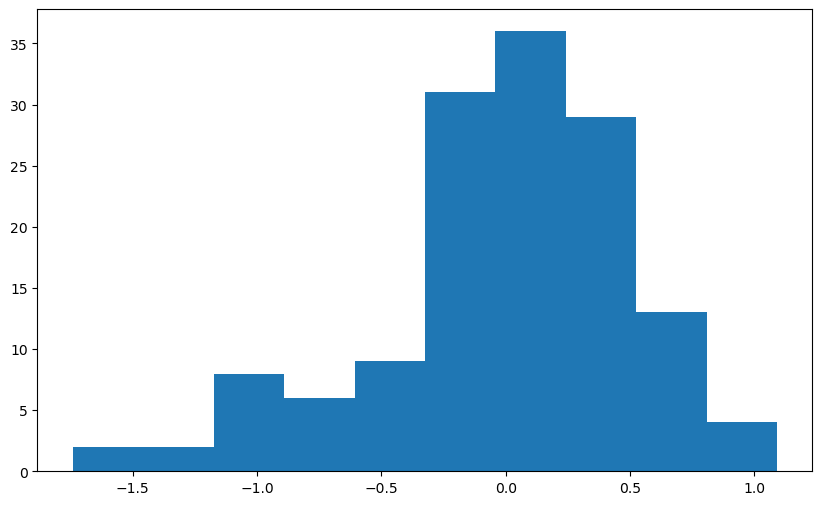

In [128]:
#Testare normalitate
testare_normalitate(regresie=regresie,bins=10)

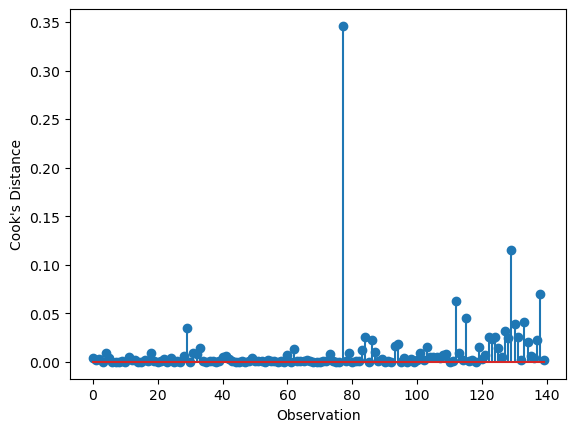

In [135]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)
plt.stem(cooks_d)
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.show()

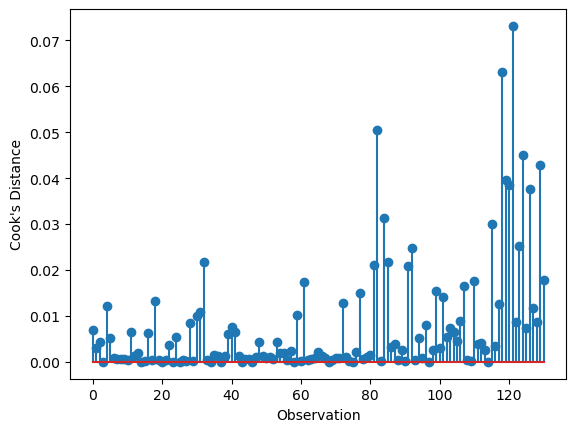

In [145]:
influence = regresie_cook.get_influence()
cooks_d, p_values = influence.cooks_distance
# df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)
plt.stem(cooks_d)
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.show()

In [144]:
influential

,Region,happy,upperwhisker,lowerwhisker,GDP_capita_logged,Social_support,Life_expectancy,Freedom,Generosity,Coruption,Dystopia + residual,Region_2,cooks_d
Country name,,,,,,,,,,,,,
Hong Kong S.A.R. of China,East Asia,5.316,5.403,5.229,1.909,1.184,0.857,0.485,0.147,0.402,0.333,Asia,0.050410
Congo (Brazzaville),Sub-Saharan Africa,5.221,5.396,5.047,0.892,0.622,0.306,0.523,0.124,0.138,2.617,Africa,0.031264
India,South Asia,4.054,4.123,3.985,1.166,0.653,0.417,0.767,0.174,0.122,0.756,Asia,0.063212
Egypt,Middle East and North Africa,3.977,4.066,3.887,1.370,0.996,0.488,0.490,0.025,0.259,0.349,Africa,0.039641
Sri Lanka,South Asia,3.898,4.018,3.778,1.361,1.179,0.586,0.583,0.144,0.031,0.014,Asia,0.038438
Bangladesh,South Asia,3.886,3.994,3.778,1.122,0.249,0.513,0.775,0.140,0.167,0.919,Asia,0.073140
Eswatini,Sub-Saharan Africa,3.502,3.673,3.331,1.255,0.925,0.176,0.284,0.059,0.116,0.686,Africa,0.045037
Zimbabwe,Sub-Saharan Africa,3.341,3.457,3.226,0.748,0.850,0.232,0.487,0.096,0.131,0.797,Africa,0.037735
Lesotho,Sub-Saharan Africa,3.186,3.469,2.904,0.771,0.851,0.000,0.523,0.082,0.085,0.875,Africa,0.042852


In [146]:
regresie_cook = smf.ols('happy ~Social_support + '
                            '+ Coruption +GDP_capita_logged + Freedom',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues
weigths = 1 / (np.power(fit,2))
# wls = sm.WLS(df.loc[df.dropna().index,'happy'],exog=exog,weights=weigths).fit()

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     235.9
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           5.22e-55
Time:                        00:06:25   Log-Likelihood:                -45.606
No. Observations:                 122   AIC:                             101.2
Df Residuals:                     117   BIC:                             115.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5737      0.15

Testul White
(9.800613078774445, 0.7766107893225401, 0.6676033419512397, 0.8009439217216799)
Test Breuche-Pagan
(6.779188640390626, 0.14802745622994964, 1.720967465786625, 0.1499571971370753)


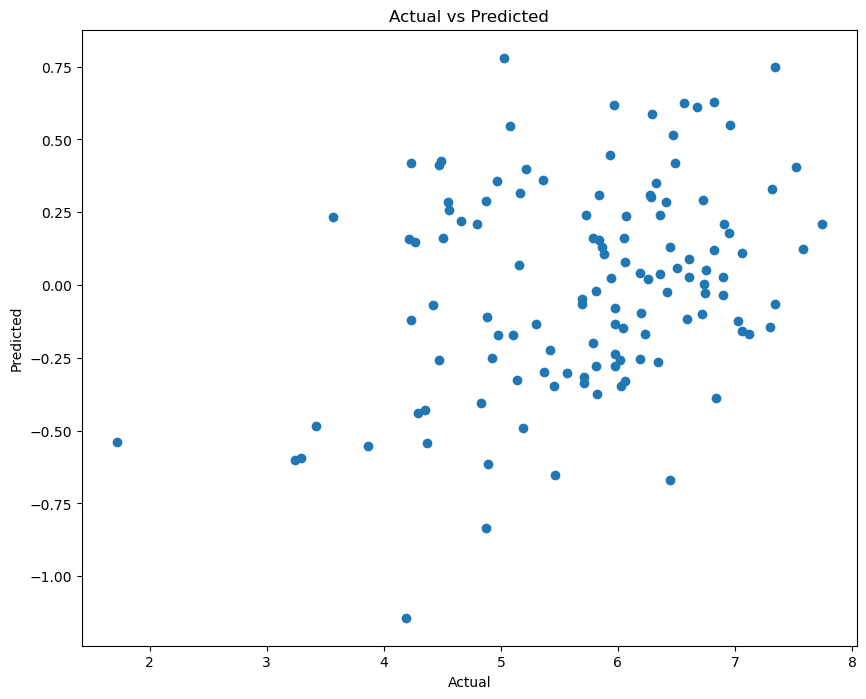

In [147]:
testare_homoschedasticitate(regresie_cook,df_with_cook.loc[df_with_cook.dropna().index,'happy'])

jarque_bera
(1.1969126806781951, 0.5496594686922319, -0.24218947242259753, 3.0289010389989444)
SHAPIRO
ShapiroResult(statistic=0.9928030967712402, pvalue=0.7859604954719543)
Kolmogov Smirnov
KstestResult(statistic=0.03728716013439726, pvalue=0.9934957379186222, statistic_location=0.10717367785428955, statistic_sign=-1)


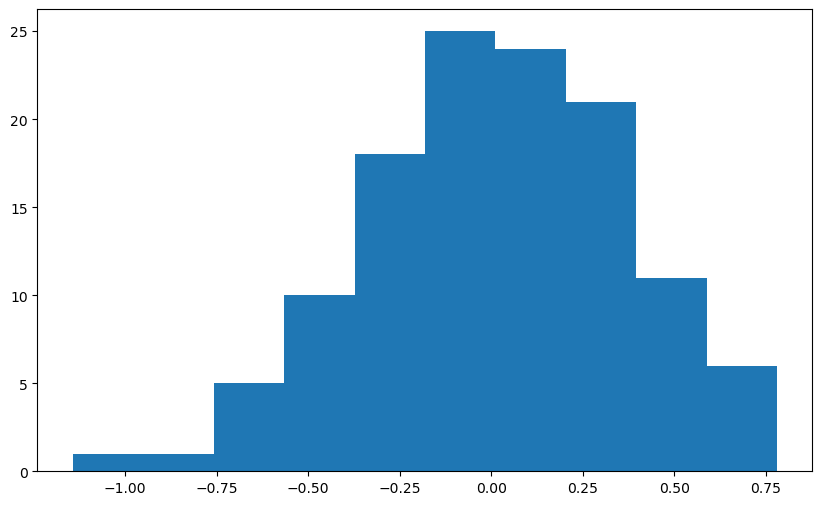

In [148]:
testare_normalitate(regresie_cook,bins=10)

Verificare Multicoloniaritate + Matrice de corelatii

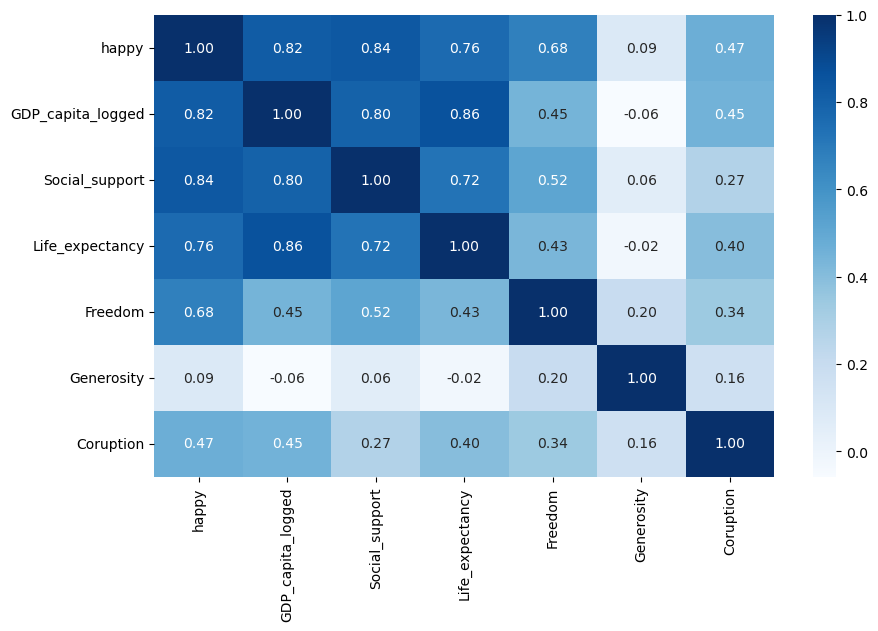

In [ ]:
col = list(df.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [149]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie.params.index)))}
vif

{'Intercept': 21.529035306098116,
 'Social_support': 3.5591217655208647,
 'Coruption': 1.385607386526468,
 'GDP_capita_logged': 3.427761389821758,
 'Freedom': 1.6023285927376782}

## To do pt Philipe

1. df.describe() si scrii intr-un document word concluziile pe care le obtii din date (Pt proiect)
2. Cauta surse de date care sa fie cat de cat similare cu ceea ce avem noi (GDP per capita!!!) (Pt proiect)
3. Reformuleaza definitiile de pe kaggle a.i. sa aiba  (Pt proiect)
4. Joaca-te cu diverse forme ale modelului: Baga si scoate variabile din model, vezi care sunt sau nu  (Pt tine + pt proiect)
5. Testeaza ipotezele de normalitate, homoschedasticitate, multicoliniaritate (Pt tine)
6. Intrepreteaza parametriii (Pt tine)

In [150]:
# regresie.summary()

# Rezultate finale obtinute
###
#
Eliminarea a 18 instante utilizand distante Cook, obtinem urmatorul model
### Forma finala a modelului: 
### Happines Index = 1.64 + 0.71 * Coruptie + 1.66 * ln(PIB) + 2.58 * IndiceLibertate

In [151]:
regresie_cook = smf.ols('happy ~ Coruption +GDP_capita_logged + Freedom',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues
weigths = 1 / (np.power(fit,2))

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     224.2
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           1.47e-48
Time:                        00:20:41   Log-Likelihood:                -64.046
No. Observations:                 122   AIC:                             136.1
Df Residuals:                     118   BIC:                             147.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.6459      0.17

jarque_bera
(2.880365557329385, 0.23688445730016616, -0.3698372717988325, 3.139681278344746)
SHAPIRO
ShapiroResult(statistic=0.9871652126312256, pvalue=0.3068663477897644)
Kolmogov Smirnov
KstestResult(statistic=0.06390026806396842, pvalue=0.6773162859145871, statistic_location=-0.11282776458047561, statistic_sign=-1)


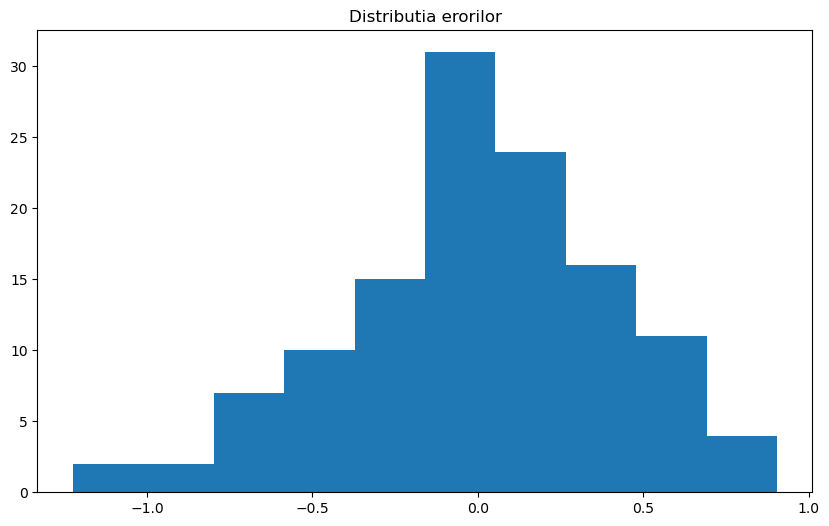

In [158]:
testare_normalitate(regresie=regresie_cook,bins=10)

Testul White
(15.396860931032343, 0.08059595231893735, 1.7973709043512185, 0.0763559140378347)
Test Breuche-Pagan
(8.220521507800957, 0.041667403125131994, 2.841817495782775, 0.04082071952864869)


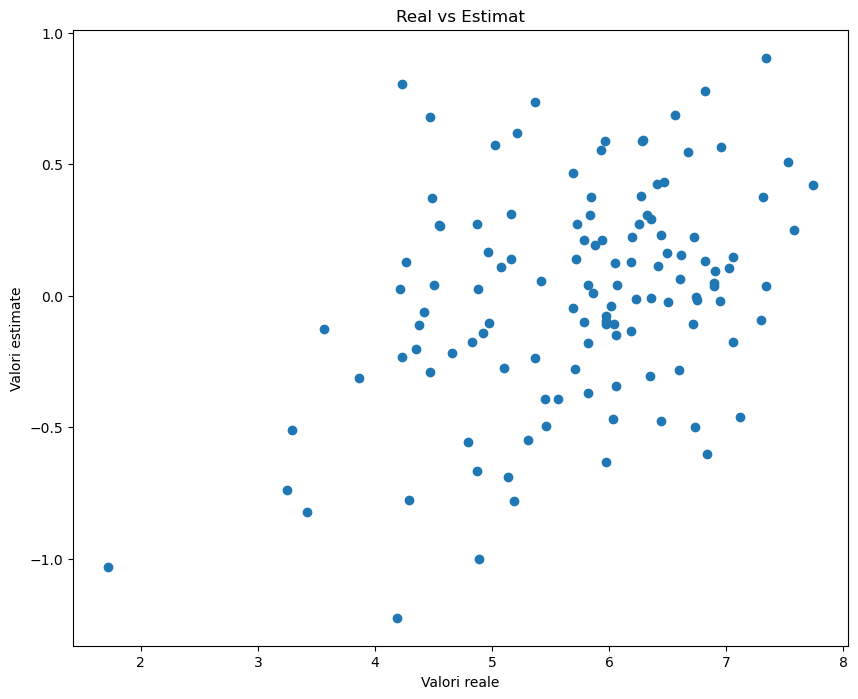

In [159]:
testare_homoschedasticitate(regression=regresie_cook,actual=df_with_cook.loc[df_with_cook.dropna().index,'happy'])

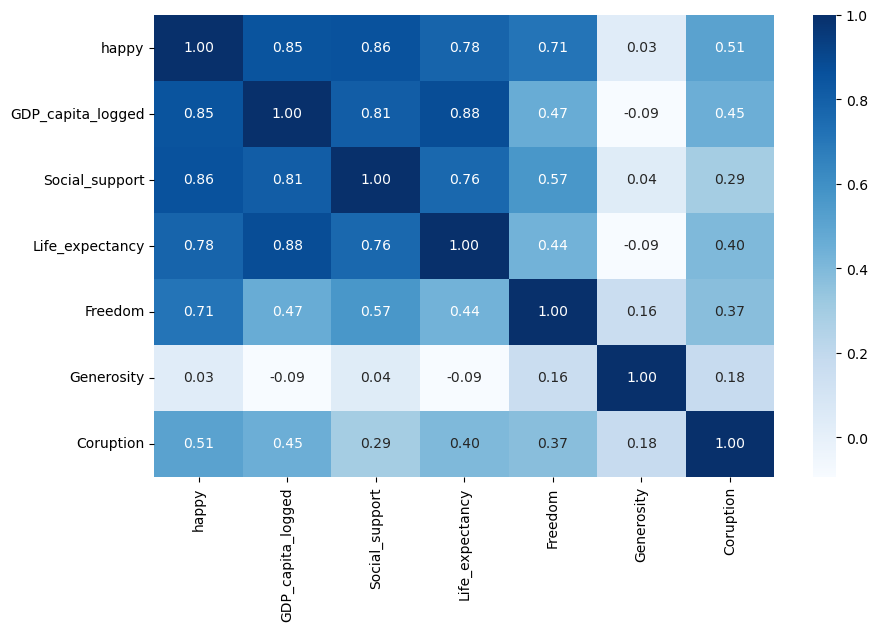

In [160]:
col = list(df.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [155]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie.params.index)))}
vif

{'Intercept': 21.409732616016363,
 'Coruption': 1.3107171545031868,
 'GDP_capita_logged': 1.438666826617619,
 'Freedom': 1.3336506930260608}